In [2]:
import sleap_io as sio
from matplotlib import pyplot as plt

from movement import sample_data
from movement.filtering import interpolate_over_time
from movement.io import load_bboxes

SHA256 hash of downloaded file: 40a6d79722dcaf7cee39627959e46a1bc10a6e1405842a7c2993d6d69b4c8195
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [3]:
dataset_dict = sample_data.fetch_dataset_paths(
    "VIA_single-crab_MOCA-crab-1.csv",
    with_video=True,  # download associated video
)

file_path = dataset_dict["bboxes"]
print(file_path)

ds = load_bboxes.from_via_tracks_file(
    file_path, use_frame_numbers_from_file=True
)

/home/mahima/.movement/data/bboxes/VIA_single-crab_MOCA-crab-1.csv


In [4]:
print(ds)

<xarray.Dataset> Size: 2kB
Dimensions:      (time: 35, space: 2, individuals: 1)
Coordinates:
  * time         (time) int64 280B 0 5 10 15 20 25 ... 145 150 155 160 165 167
  * space        (space) <U1 8B 'x' 'y'
  * individuals  (individuals) <U4 16B 'id_1'
Data variables:
    position     (time, space, individuals) float64 560B 1.118e+03 ... 401.9
    shape        (time, space, individuals) float64 560B 320.1 153.2 ... 120.1
    confidence   (time, individuals) float64 280B nan nan nan ... nan nan nan
Attributes:
    fps:              None
    time_unit:        frames
    source_software:  VIA-tracks
    source_file:      /home/mahima/.movement/data/bboxes/VIA_single-crab_MOCA...
    ds_type:          bboxes


Ispecting associated video

In [5]:
video_path = dataset_dict["video"]

video = sio.load_video(video_path)
n_frames, height, width, channels = video.shape

print(f"Number of frames: {n_frames}")
print(f"Frame size: {width}x{height}")
print(f"Number of channels: {channels}")

Number of frames: 168
Frame size: 1280x720
Number of channels: 3


In [6]:
print(ds.time)

<xarray.DataArray 'time' (time: 35)> Size: 280B
0 5 10 15 20 25 30 35 40 45 50 ... 120 125 130 135 140 145 150 155 160 165 167
Coordinates:
  * time     (time) int64 280B 0 5 10 15 20 25 30 ... 145 150 155 160 165 167


In [7]:
ds_nan = ds.reindex(
    {"time": list(range(ds.time[-1].item() + 1))},
    method=None,  # default
)

In [8]:
ds_interp = ds_nan.copy()

In [16]:
for data_array_str in ["position", "shape"]:
    ds_interp[data_array_str] = interpolate_over_time(
        data=ds_interp[data_array_str],
        method="linear",
        max_gap=None,
        print_report=False,
    )

In [10]:
print(ds_interp)

<xarray.Dataset> Size: 8kB
Dimensions:      (time: 168, space: 2, individuals: 1)
Coordinates:
  * time         (time) int64 1kB 0 1 2 3 4 5 6 ... 161 162 163 164 165 166 167
  * space        (space) <U1 8B 'x' 'y'
  * individuals  (individuals) <U4 16B 'id_1'
Data variables:
    position     (time, space, individuals) float64 3kB 1.118e+03 ... 401.9
    shape        (time, space, individuals) float64 3kB 320.1 153.2 ... 120.1
    confidence   (time, individuals) float64 1kB nan nan nan nan ... nan nan nan
Attributes:
    fps:              None
    time_unit:        frames
    source_software:  VIA-tracks
    source_file:      /home/mahima/.movement/data/bboxes/VIA_single-crab_MOCA...
    ds_type:          bboxes


In [11]:
print(ds_interp.time)

<xarray.DataArray 'time' (time: 168)> Size: 1kB
0 1 2 3 4 5 6 7 8 9 10 11 12 ... 156 157 158 159 160 161 162 163 164 165 166 167
Coordinates:
  * time     (time) int64 1kB 0 1 2 3 4 5 6 7 ... 161 162 163 164 165 166 167


In [12]:
print(ds_interp.position.sel(time=0).data)
print(ds_interp.position.sel(time=1).data)
print(ds_interp.position.sel(time=2).data)
print(ds_interp.position.sel(time=3).data)
print(ds_interp.position.sel(time=4).data)
print(ds_interp.position.sel(time=5).data)

[[1117.895 ]
 [ 373.3035]]
[[1113.9442]
 [ 373.8679]]
[[1109.9934]
 [ 374.4323]]
[[1106.0426]
 [ 374.9967]]
[[1102.0918]
 [ 375.5611]]
[[1098.141 ]
 [ 376.1255]]


In [13]:
def plot_position_and_shape_xy_coords(ds_input_data, ds_filled, color_filled):
    """Compare the x and y coordinates of the position and shape arrays in time
    for the input and filled datasets.
    """
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))
    for row in range(axs.shape[0]):
        space_coord = ["x", "y"][row]
        for col in range(axs.shape[1]):
            ax = axs[row, col]
            data_array_str = ["position", "shape"][col]

            # plot original data
            ax.scatter(
                x=ds_input_data.time,
                y=ds_input_data[data_array_str].sel(
                    individuals="id_1", space=space_coord
                ),
                marker="o",
                color="black",
                label="original data",
            )

            # plot forward filled data
            ax.plot(
                ds_filled.time,
                ds_filled[data_array_str].sel(
                    individuals="id_1", space=space_coord
                ),
                marker=".",
                linewidth=1,
                color=color_filled,
                label="upsampled data",
            )

            # set axes labels and legend
            ax.set_ylabel(f"{space_coord} (pixels)")
            if row == 0:
                ax.set_title(f"Bounding box {data_array_str}")
                if col == 1:
                    ax.legend()
            if row == 1:
                ax.set_xlabel("time (frames)")

    fig.tight_layout()

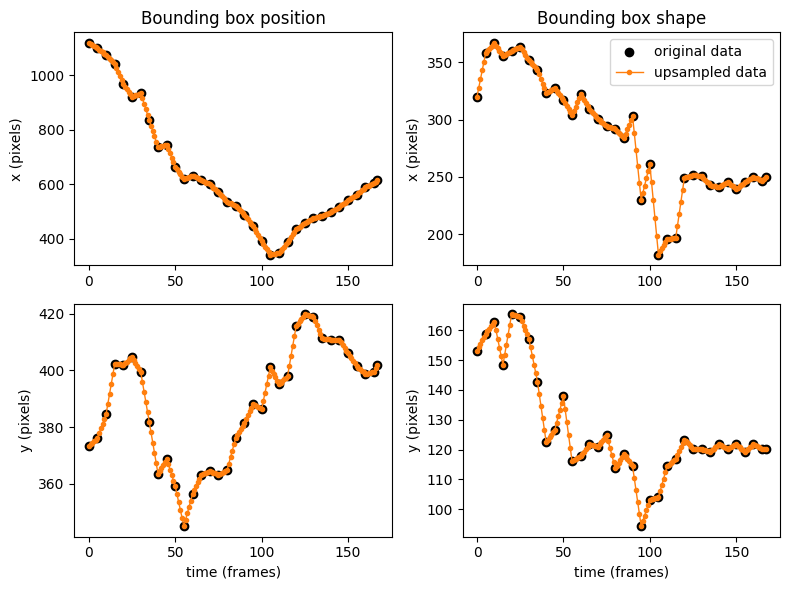

In [14]:
plot_position_and_shape_xy_coords(
    ds, ds_filled=ds_interp, color_filled="tab:orange"
)

In [17]:
ds_interp.attrs["fps"] = 24.0  # Assign a meaningful value or another number

In [22]:
# Convert problematic attributes to strings
for var in ds_interp.variables:
    for attr in list(ds_interp[var].attrs):
        if isinstance(ds_interp[var].attrs[attr], (list, tuple, dict, set)):
            ds_interp[var].attrs[attr] = str(ds_interp[var].attrs[attr])

# Remove problematic global attributes
for attr in list(ds_interp.attrs):
    if isinstance(ds_interp.attrs[attr], (list, tuple, dict, set)):
        ds_interp.attrs[attr] = str(ds_interp.attrs[attr])

ds_interp.to_netcdf(
    "final_upsampled_dataset.nc",
    format="NETCDF4",
    engine="netcdf4",
    unlimited_dims="time",
)